In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from numpy import sqrt 
import pickle
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared, Matern, RationalQuadratic
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mc90v-full/M2508_train_sensors.csv
/kaggle/input/mc90v-full/M2508_test_sensors.csv
/kaggle/input/mc90v-full/M2508_train_full.csv
/kaggle/input/mc90v-full/M2503_test_full.csv
/kaggle/input/mc90v-full/M2503_train_full.csv
/kaggle/input/mc90v-full/M0000_test_sensors.csv
/kaggle/input/mc90v-full/M2503_train_sensors.csv
/kaggle/input/mc90v-full/M2506_test_full.csv
/kaggle/input/mc90v-full/M0000_train_full.csv
/kaggle/input/mc90v-full/M0000_test_full.csv
/kaggle/input/mc90v-full/M2506_train_sensors.csv
/kaggle/input/mc90v-full/M2506_train_full.csv
/kaggle/input/mc90v-full/M2503_test_sensors.csv
/kaggle/input/mc90v-full/M0000_train_sensors.csv
/kaggle/input/mc90v-full/M2506_test_sensors.csv
/kaggle/input/mc90v-full/M2508_test_full.csv


In [ ]:
m2503_train = pd.read_csv('/kaggle/input/mc90v-full/M2503_train_sensors.csv')
m2503_test = pd.read_csv('/kaggle/input/mc90v-full/M2503_test_sensors.csv')

In [ ]:
m2503_train

### Preprocessing

In [ ]:
def calculate_RunId_X(df):
    
    if df['Load'] == 0:
        return df['RunId'] * 2 -1
    else:
        return df['RunId'] * 2
    
    
def resample(df):
        df = df.groupby(df.index // 10).mean()
        return df
        

def preprocessing(df):
    
    # Getting only SeaTemp = 20 and Windspeed = 0
    df = df[(df.SeaTemp == 'SW20') & (df.WindSpeed == 'WC0')]
    
    # select features
    abr_sensor_list = ['E02005', 'E02006', 'E02056', 'E03760', 'G00027', 'G00108', 'G02011', 'N02015', 'P00023', 'P01005', 'P01302', 'P01303', 'P01600', 'P01602', 'P02055', 'P02065', 'P02066', 'P02071', 'P02072', 'Q02004', 'T00002', 'T01010', 'T01011', 'T01350', 'T01351', 'T01601', 'T01603', 'T02014', 'T02040', 'T02041', 'T02042', 'T02044', 'T04600', 'Z00518', 'Z01970', 'Z02013']
    ic = ['Load','RunId']
    ic.extend(abr_sensor_list)
    df = df[ic]
    
    # LoadType 0-1
    df['Load'] = df['Load'].apply(lambda x: 0 if x == 'FAL' else 1)
    
    # interpolate
    df = df.interpolate().fillna(df.mean())
    
    # create RunID_X column
    runId_column = df.apply(calculate_RunId_X, axis=1)
    df['RunID_X'] = runId_column
    df['RunID_X'] = df['RunID_X'].astype(int)
    
    # resampling
    df = df.groupby('RunID_X').apply(resample)
    
    # drop Load, RunId, RunID_X
    df = df.drop(['Load','RunId', 'RunID_X'], axis =1 )

    
    #--------------feature extraction----------------
    min_values = df.groupby('RunID_X').min()
    max_values = df.groupby('RunID_X').max()
    
    df = df.join(pd.DataFrame(min_values.values, index=min_values.index, columns=min_values.columns + '_min_value'))
    df = df.join(pd.DataFrame(max_values.values, index=max_values.index, columns=max_values.columns + '_max_value'))
    #--------------feature extraction----------------
    
    df = df.drop(['Z02013_min_value','Z02013_max_value'], axis = 1)

    return df

In [ ]:
def train_test(df_train, df_test):
    
    # X_train - X_test - smokeContent_train - smokeContent_test
    smokeContent_train = df_train['Z02013'] 
    smokeContent_test = df_test['Z02013']

    X_train = df_train.drop(['Z02013'], axis = 1)
    X_test = df_test.drop(['Z02013'], axis = 1)
    
    return X_train, smokeContent_train, X_test, smokeContent_test

In [ ]:
def scale_data(X_train, smokeContent_train, X_test, smokeContent_test):
    
    x_train_scaler = MinMaxScaler()
    X_train_scaled = x_train_scaler.fit_transform(X_train)

    x_test_scaler = MinMaxScaler()
    X_test_scaled = x_test_scaler.fit_transform(X_test)

    smokeContent_train_scaler = MinMaxScaler()
    smokeContent_train_scaled = smokeContent_train_scaler.fit_transform(np.array(smokeContent_train).reshape(-1,1))

    smokeContent_test_scaler = MinMaxScaler()
    smokeContent_test_scaled = smokeContent_test_scaler.fit_transform(np.array(smokeContent_test).reshape(-1,1))
    
    return X_train_scaled, smokeContent_train_scaled, X_test_scaled, smokeContent_test_scaled, smokeContent_test_scaler

In [ ]:
m2503_train = preprocessing(m2503_train)
m2503_test = preprocessing(m2503_test)

M2503_X_train, M2503_smokeContent_train, M2503_X_test, M2503_smokeContent_test = train_test(m2503_train, m2503_test)

M2503_X_train_scaled, M2503_smokeContent_train_scaled, M2503_X_test_scaled, M2503_smokeContent_test_scaled, M2503_smokeContent_test_scaler = scale_data( M2503_X_train, M2503_smokeContent_train, M2503_X_test, M2503_smokeContent_test)

### Model

#### Matern

In [ ]:
matern_kernel = Matern(length_scale=1.0, nu=1.5)
gpr_m2503_matern = GaussianProcessRegressor(kernel=matern_kernel, alpha=1e-5, random_state=42)

gpr_m2503_matern.fit(M2503_X_train_scaled, M2503_smokeContent_train_scaled)

m2503_filename = 'm2503_matern_ts.pkl'
pickle.dump(gpr_m2503_matern, open(m2503_filename, 'wb'))

#### Rational Quadratic

In [ ]:
kernel_rq = RationalQuadratic(length_scale=1.0, alpha=1.5)
gpr_m2503_rq = GaussianProcessRegressor(kernel=kernel_rq, alpha=1.5, random_state = 42)

gpr_m2503_rq.fit(M2503_X_train_scaled, M2503_smokeContent_train_scaled)

m2503_filename = 'm2503_rq_ts.pkl'
pickle.dump(gpr_m2503_rq, open(m2503_filename, 'wb'))


#### RBF + Linear

In [ ]:
kernel = ConstantKernel() * RBF() + WhiteKernel()

gpr_m2503_rbf = GaussianProcessRegressor(kernel=kernel, alpha=0.1, random_state = 42)

gpr_m2503_rbf.fit(M2503_X_train_scaled, M2503_smokeContent_train_scaled)

m2503_filename = 'm2503_rbf_ts.pkl'
pickle.dump(gpr_m2503_rbf, open(m2503_filename, 'wb'))

### Predictions

In [ ]:
def predict_smokeContent(X_test_scaled, smokeContent_test_scaler, gpr):
    
    smokeContent_pred_scaled = gpr.predict(X_test_scaled, return_std=False)
    smokeContent_pred_scaled = smokeContent_pred_scaled.flatten()
    smokeContent_pred_scaled = smokeContent_pred_scaled.reshape(-1, 1)
    smokeContent_pred = smokeContent_test_scaler.inverse_transform(smokeContent_pred_scaled)
    
    return smokeContent_pred

In [ ]:
M2503_smokeContent_pred_matern = predict_smokeContent(M2503_X_test_scaled, M2503_smokeContent_test_scaler, gpr_m2503_matern)
M2503_smokeContent_pred_rq = predict_smokeContent(M2503_X_test_scaled, M2503_smokeContent_test_scaler, gpr_m2503_rq)
M2503_smokeContent_pred_rbf = predict_smokeContent(M2503_X_test_scaled, M2503_smokeContent_test_scaler, gpr_m2503_rbf)

### RMSE

In [38]:
M2503_rmse_matern = sqrt(mean_squared_error(M2503_smokeContent_test, M2503_smokeContent_pred_matern))
print("RMSE | [Matern: ", M2503_rmse_matern)

M2503_rmse_rq = sqrt(mean_squared_error(M2503_smokeContent_test, M2503_smokeContent_pred_rq))
print("RMSE | [Rational Quadratic: ", M2503_rmse_rq)

M2503_rmse_rbf = sqrt(mean_squared_error(M2503_smokeContent_test, M2503_smokeContent_pred_rbf))
print("RMSE | [RBF + Linear: ", M2503_rmse_rbf)

RMSE | [Matern:  0.1661314812186628
RMSE | [Rational Quadratic:  0.3277625067465095
RMSE | [RBF + Linear:  0.18627529130070608


### MAE

In [37]:
M2503_mae_matern = mean_absolute_error(M2503_smokeContent_test, M2503_smokeContent_pred_matern)
print("MAE | [Matern: ", M2503_mae_matern)

M2503_mae_rq = mean_absolute_error(M2503_smokeContent_test, M2503_smokeContent_pred_rq)
print("MAE | [Rational Quadratic: ", M2503_mae_rq)

M2503_mae_rbf = mean_absolute_error(M2503_smokeContent_test, M2503_smokeContent_pred_rbf)
print("MAE | [RBF + Linear: ", M2503_mae_rbf)

MAE | [Matern:  0.1299547165389077
MAE | [Rational Quadratic:  0.20959506574952377
MAE | [RBF + Linear:  0.13356291878368598


In [ ]:
M2503_X_test['Z02013'] = M2503_smokeContent_test
M2503_X_test['pred_matern'] = M2503_smokeContent_pred_matern
M2503_X_test['pred_rq'] = M2503_smokeContent_pred_rq
M2503_X_test['pred_rbf'] = M2503_smokeContent_pred_rbf

### Visualization

In [ ]:
def model_plot(runid, M2503_X_test):
    
    runid_x = runid * 2 -1
    plt.figure(figsize=(14, 8)) 
    
    #FAL
    plt.suptitle("M2503 - Smoke Content   |  "  +  "  RunId: " + str(runid) )
    
    plt.subplot(2, 2, 1) 
    
    smokeContent_fal = M2503_X_test.loc[runid_x]['Z02013'] 
    m2503_pred_matern_fal = M2503_X_test.loc[runid_x]['pred_matern']
    m2503_pred_rq_fal = M2503_X_test.loc[runid_x]['pred_rq']
    m2503_pred_rbf_fal = M2503_X_test.loc[runid_x]['pred_rbf']
    
    
    plt.plot(smokeContent_fal.values,label="Ground Truth", color="red")  
    plt.plot(m2503_pred_matern_fal.values ,label="Matern", color="green")
    plt.plot(m2503_pred_rq_fal.values ,label="Rational Quadratic", color="black")
    plt.plot(m2503_pred_rbf_fal.values ,label="RBF + Linear", color="blue")
    
    plt.legend(loc="lower right")

    plt.tight_layout()
    title_ = "FAL"
    plt.title(title_)
    
    plt.subplot(2, 2, 2) 

    #FAU
    smokeContent_fau = M2503_X_test.loc[runid_x + 1]['Z02013'] 
    m2503_pred_matern_fau = M2503_X_test.loc[runid_x + 1]['pred_matern']
    m2503_pred_rq_fau = M2503_X_test.loc[runid_x + 1]['pred_rq']
    m2503_pred_rbf_fau = M2503_X_test.loc[runid_x + 1]['pred_rbf']

    plt.plot(smokeContent_fau.values,label="Ground Truth", color="red")  
    plt.plot(m2503_pred_matern_fau.values ,label="Matern", color="green")
    plt.plot(m2503_pred_rq_fau.values ,label="Rational Quadratic", color="black")
    plt.plot(m2503_pred_rbf_fau.values ,label="RBF + Linear", color="blue")

    plt.legend(loc="lower right")

    plt.tight_layout()
    title_ = "FAU"
    plt.title(title_)
    plt.show()

/tmp/ipykernel_32/2600917705.py:43: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


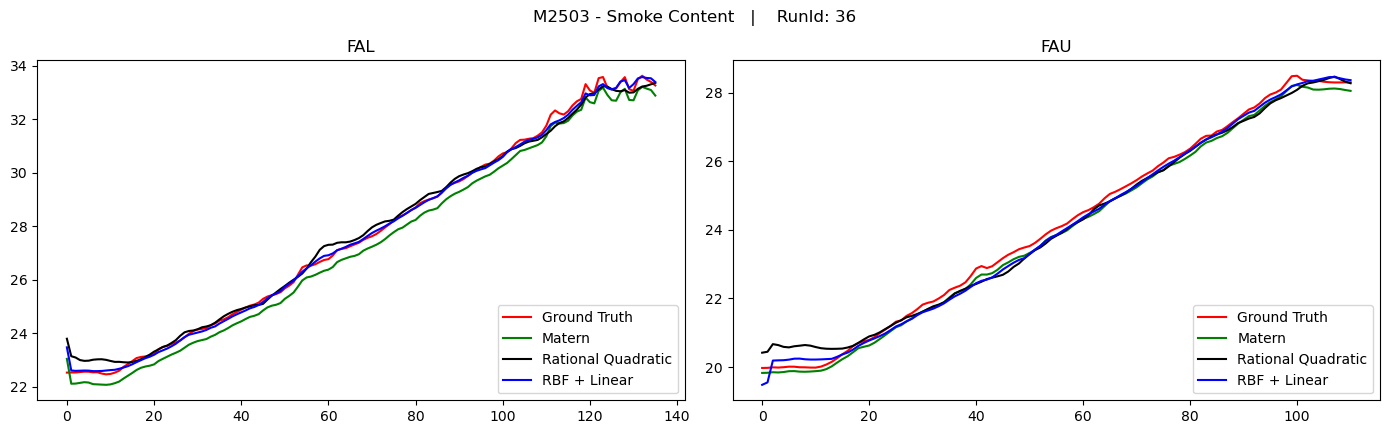

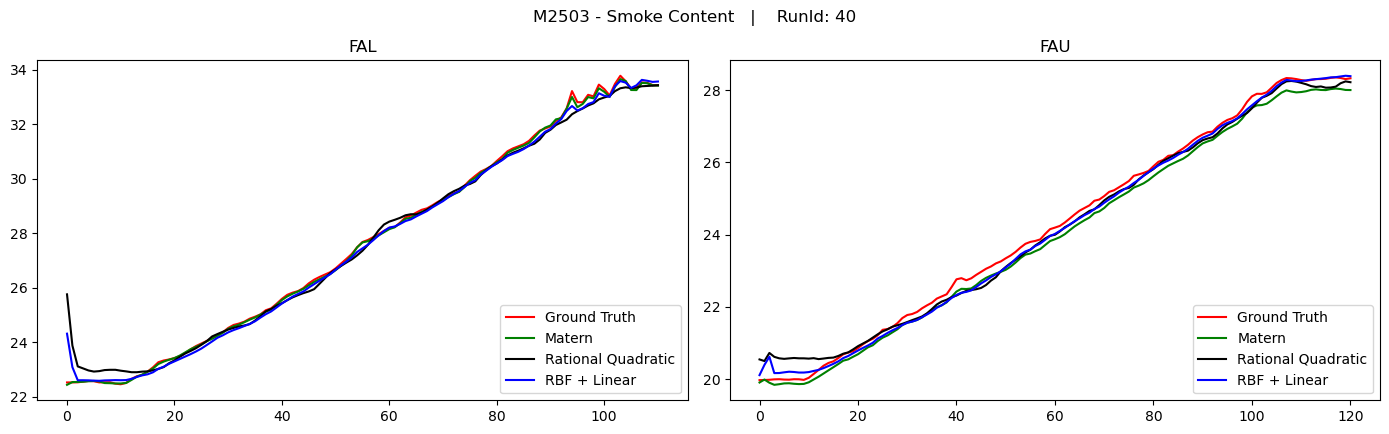

In [33]:
# RunID : 36  |  M2503 
model_plot(36, M2503_X_test)

# RunID : 40  |  M2503 
model_plot(40, M2503_X_test)